In [1]:
%matplotlib inline
import hydrofunctions as hf
import urllib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import math
import gdal
from gdalconst import GA_ReadOnly
plt.ion()
# set standard plot parameters for uniform plotting
plt.rcParams['figure.figsize'] = (11, 6)
# prettier plotting with seaborn
import seaborn as sns; 
sns.set(font_scale=1.5)
sns.set_style("whitegrid")
import earthpy as et
# set working dir and import earthpy
#os.chdir(os.path.join(et.io.HOME, 'earth-analytics'))

/home/aroja164/anaconda3/envs/flood02/lib/python3.6/site-packages/hydrofunctions/charts.py:13: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "/home/aroja164/anaconda3/envs/flood02/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/home/aroja164/anaconda3/envs/flood02/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/aroja164/.local/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/aroja164/.local/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/home/aroja164/.local/lib/python3.6/site-packages

In [2]:
import matplotlib.dates as dates
import scipy.stats as sp
import scipy.optimize as op
#import statsmodels.api as sm
#import ulmo
#from pandas.stats.api import ols #HELP TODO, it can be fixed by 
#install gdal downgrade:
#conda install gdal "libgfortran-ng=7.2.0=hdf63c60_3" 
#but it will conflicting with ulmo, 
#next try another version, downgrade?
from datetime import datetime, date, timedelta
from matplotlib.backends.backend_pdf import PdfPages
from matplotlib.pyplot import cm 
from pylab import rcParams
rcParams['figure.figsize'] = 10, 8
import logging
# logging.basicConfig()conda install gdal "libgfortran-ng=7.2.0=hdf63c60_3" 
# logger = logging.getLogger('ulmo.usgs.nwis.core')
# logger.setLevel(logging.WARNING)
#import rpy2

In [3]:
def importusgssite(siteno):
    sitename = {}
    sitename = ulmo.usgs.nwis.get_site_data(siteno, service="daily", period="all")
    sitename = pd.DataFrame(sitename['00060:00003']['values'])
    sitename['dates'] = pd.to_datetime(pd.Series(sitename['datetime']))
    sitename.set_index(['dates'],inplace=True)
    sitename[siteno] = sitename['value'].astype(float)
    sitename[str(siteno)+'qual'] = sitename['qualifiers']
    sitename = sitename.drop(['datetime','qualifiers','value'],axis=1)
    sitename = sitename.replace('-999999',np.NAN)
    sitename = sitename.dropna()
    #sitename['mon']=sitename.index.month
    return sitename


def getusgssiteinfo(siteno):
    siteinfo = ulmo.usgs.nwis.get_site_data(siteno, service="daily", period="all")
    siteinfo = pd.DataFrame(siteinfo['00060:00003']['site'])
    siteinfo['latitude'] = siteinfo.loc['latitude','location']
    siteinfo['longitude'] = siteinfo.loc['longitude','location']
    siteinfo['latitude'] = siteinfo['latitude'].astype(float)
    siteinfo['longitude'] = siteinfo['longitude'].astype(float)
    siteinfo = siteinfo.drop(['default_tz','dst_tz','srs','uses_dst','longitude'],axis=0)
    siteinfo = siteinfo.drop(['agency','timezone_info','location','state_code','network'],axis=1)
    return siteinfo



### First exploration to find the stations

In [4]:
# create map of stations
hf.draw_map()

In [5]:
demfile = 'DEM/DEM_LONLAT.tif'
dem = gdal.Open(demfile, GA_ReadOnly)
geoTransform = dem.GetGeoTransform()
minx = geoTransform[0]
maxy = geoTransform[3]
maxx = minx + geoTransform[1] * dem.RasterXSize
miny = maxy + geoTransform[5] * dem.RasterYSize
dem = None
minx = round(minx, 2)
maxy = round(maxy, 2)
maxx = round(maxx, 2)
miny = round(miny, 2)
#print([minx, miny, maxx, maxy])

In [6]:
[minx, maxy, maxx, miny]

[-96.0, 30.24, -95.26, 29.82]

In [18]:
# Request data for all stations in Bounding Box
start = '2015-01-01'
end = '2019-06-30'

Requests  = hf.NWIS(bBox=[minx, miny, maxx, maxy], service='iv', start_date = start, end_date=end).get_data()
RequestsProperty = hf.NWIS(bBox=[minx, miny, maxx, maxy]).get_data().json()
# StreamFlow.response.ok
StreamFlow = Requests.df()

Loc = hf.get_nwis_property(RequestsProperty, key='geoLocation', remove_duplicates=True) 
Name = hf.get_nwis_property(RequestsProperty, key='siteName', remove_duplicates=True) 
code_raw = hf.get_nwis_property(RequestsProperty, key='siteCode', remove_duplicates=True)



/home/aroja164/anaconda3/envs/flood02/lib/python3.6/site-packages/hydrofunctions/hydrofunctions.py:364: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  DF = pd.concat([DF, dfa], axis=1)


### Merge location and properties

In [19]:
X = []
Y = []
Code = []

counter = 0
for i,val in Loc:    
    X.append(Loc[counter]['geogLocation']['longitude'])
    Y.append(Loc[counter]['geogLocation']['latitude'])
    Code.append(code_raw[counter][0]['value'])
    counter = counter + 1


d = {'X':X, 'Y':Y, 'Name':Name, 'Code':Code}
#merge in pandas dataframe
df = pd.DataFrame(d) #, columns=['X', 'Y', 'Name']))

In [17]:
import geopandas
from shapely.geometry import Point
gdf = geopandas.GeoDataFrame(
    df, geometry=geopandas.points_from_xy(df.X, df.Y))
gdf.to_file('Point_USGS.shp', driver='ESRI Shapefile')

### Take only discharge data for each stations

In [20]:
StreamFlow = StreamFlow[StreamFlow.columns.drop(list(StreamFlow.filter(regex='_qualifiers')))]
#convert to m3/s
StreamFlow = StreamFlow*0.0283168

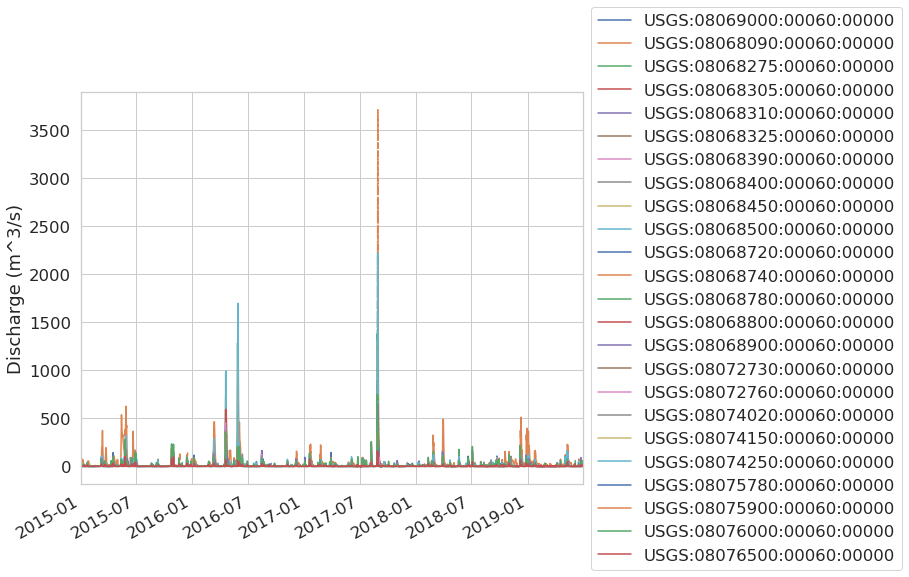

In [21]:
StreamFlow.plot()
ax = plt.gca()
#ax.get_legend().outside()
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.9, box.height])

# Put a legend to the right of the current axis
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.ylabel('Discharge (m^3/s)')
plt.show()

### Plot Location, Watersheds, and DEM

In [33]:
from mpl_toolkits.basemap import Basemap

n = 0.05 
m = Basemap(llcrnrlon=min(X)+n,llcrnrlat=min(Y)+n,urcrnrlon=max(X)+n,urcrnrlat=max(Y)+n,
            resolution='h',projection='cyl',lon_0=np.mean(X),lat_0=np.mean(Y))

#m.drawcounties(color='red',linewidth=0.5)
m.arcgisimage()
m.drawrivers(color='blue',linewidth=1.5)
#m.etopo(scale=0.5)
lons = X
lats = Y
x,y = m(lons,lats)

m.drawcoastlines()
m.drawstates()
#m.drawcountries()
m.plot(x,y,'ro', markersize=8)



# plt.text(X, Y, Name, fontsize=10)
for (lons,lats), label in zip(xy, Code):
    m.text(lons, lats, label, ha='center', size=20)

ValueError: lat_0 must be between -90.000000 and 90.000000 degrees

In [29]:
lats

[30.14116667,
 30.11993899,
 30.10549526,
 30.19055556,
 30.192159,
 30.1343832,
 30.11049517,
 29.9502237,
 29.959112,
 30.01605437,
 29.97355566,
 30.00660994,
 30.0357753,
 29.8307828,
 29.86717035,
 29.87078073,
 29.8513369,
 29.82800424,
 29.94911178,
 29.95688886,
 29.9182784,
 29.86189143]

/home/aroja164/.local/lib/python3.6/site-packages/ipykernel_launcher.py:13: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  del sys.path[0]
/home/aroja164/.local/lib/python3.6/site-packages/ipykernel_launcher.py:13: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  del sys.path[0]
/home/aroja164/.local/lib/python3.6/site-packages/ipykernel_launcher.py:17: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
/home/aroja164/.local/lib/python3.6/site-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.


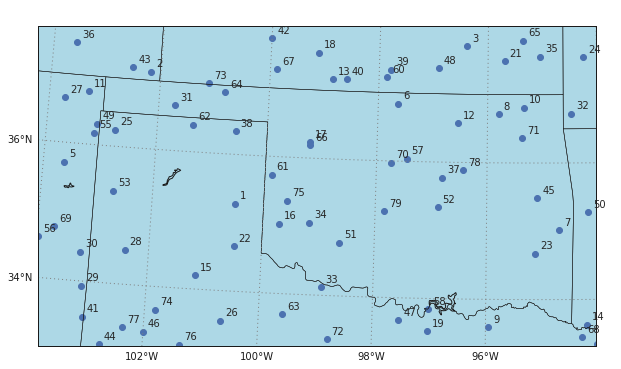

In [30]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap

num = 79
lat = 5 * np.random.random(num) + 33
lon = 10 * np.random.random(num) - 104

fig, ax = plt.subplots()
m = Basemap(projection='stere',lon_0=-95,lat_0=35.,lat_ts=40,
            llcrnrlat=33,urcrnrlat=38,
            llcrnrlon=-103.8,urcrnrlon=-94,
            resolution='h', ax=ax)

X,Y = m(lon,lat)
m.drawcoastlines()
m.drawstates()
m.drawcountries()
m.drawmapboundary(fill_color='lightblue')
m.drawparallels(np.arange(0.,40.,2.),color='gray',dashes=[1,3],labels=[1,0,0,0])
m.drawmeridians(np.arange(0.,360.,2.),color='gray',dashes=[1,3],labels=[0,0,0,1])

ax.scatter(X,Y)

for i, (x, y) in enumerate(zip(X, Y), start=1):
    ax.annotate(str(i), (x,y), xytext=(5, 5), textcoords='offset points')

plt.show()
